In [1]:
import keras
import numpy as np
import pickle
import tensorflow as tf

from keras import backend as K, regularizers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, InputLayer
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Using TensorFlow backend.


In [32]:
with open(PATH + "train_image.pkl", 'rb') as f:
    X = np.array(pickle.load(f))
    
with open(PATH + 'train_label.pkl', 'rb') as f:
    Y = np.array(pickle.load(f))

X = X/255

In [43]:
x_train, x_val, y_train, y_val = train_test_split(X, Y)

## Data Exploration

Now, let's look at what we've got here.

In [34]:
print("Dimensions of training data: ")
print(x_train.shape)
print(y_train.shape)

print("Dimensions of validation data: ")
print(x_val.shape)
print(y_val.shape)

Dimensions of training data: 
(6000, 784)
(6000,)
Dimensions of validation data: 
(2000, 784)
(2000,)


`784`, interesting - That is a (28, 28) image. Let's look at some of these below.

In [0]:
random_index = np.random.randint(0, 6001, size=(25,))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[random_index[i]].reshape((28, 28)))
    plt.xlabel(y_train[random_index[i]])
plt.show()

#### Fashion MNIST

Ah, the classic Fashion MNIST set. This is gonna be interesting. Let's try some basic machine learning techniques first.

Let's first create a helper function so that we can assess the performance of a model easily.

In [0]:
def evaluate_model(model):
    y_pred = model.predict(x_val)
    print("Classifciation Report:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:\n")
    print(confusion_matrix(y_val, y_pred))
    print("\nAccuracy of the model on validation set: {}".format(
        model.score(x_val, y_val)))
    print("Accuracy of the model on Training set: {}".format(
        model.score(x_train, y_train)))

#### Let's try SVM first

In [0]:
SVC = svm.SVC(gamma='scale').fit(x_train, y_train)
evaluate_model(SVC)

83% accuracy on first go. We're upto a great start. Let's try some other things now

In [0]:
dtree_model = DecisionTreeClassifier(max_depth = 17).fit(x_train, y_train)
evaluate_model(dtree_model)

This shows clear signs of overfitting. Let's try a different `max_depth`.

In [0]:
dtree_model = DecisionTreeClassifier(max_depth=25).fit(x_train, y_train)
evaluate_model(dtree_model)

In [0]:
knn = KNeighborsClassifier(n_neighbors = 7).fit(x_train, y_train)
evaluate_model(knn)

In [0]:
rfc = RandomForestClassifier(min_samples_leaf=20).fit(x_train, y_train)
evaluate_model(rfc)

In [0]:
rfc = RandomForestClassifier(min_samples_leaf=10).fit(x_train, y_train)
evaluate_model(rfc)

In [0]:
rfc = RandomForestClassifier(min_samples_leaf=5).fit(x_train, y_train)
evaluate_model(rfc)

In [0]:
rfc = RandomForestClassifier(min_samples_leaf=4).fit(x_train, y_train)
evaluate_model(rfc)

Hmm, SVM seems to be the winner here. Let's try a grid search for parameters in this case.

In [0]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(x_train, y_train)

In [0]:
clf.best_estimator_

In [0]:
clf.score(x_val, y_val)

In [0]:
evaluate_model(clf)

Woohoo, `85%` is decent enough accuracy for submission. Our results seem match the [standard benchmark results].

[standard benchmark results]: http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/

### Let's try a basic Convolutional Neural Network

We've already reached a pretty high accuracy bar, but according to [zalando research], many CNN based architectures have had also been pretty successful. Since, I do not have as much data as in the original Fashion MNIST, I should train on a relatively simpler architecture.

[zalando research]: [https://github.com/zalandoresearch/fashion-mnist#benchmark]

In [35]:
batch_size = 128
num_classes = 7
epochs = 20

img_rows, img_cols = 28, 28

In [36]:
# Since K.image_data_format == 'channels_last':
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

(6000,)
(2000,)


(array([1482.,    0.,    0., 1482.,    0., 1545.,    0.,    0.,    0.,
        1491.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

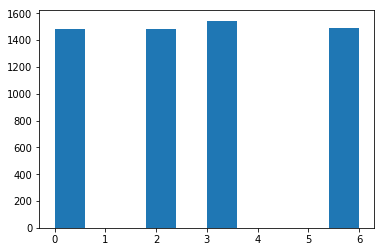

In [37]:
print(y_train.shape)
print(y_val.shape)

plt.hist(y_train)

In [38]:
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)

In [39]:
print(y_train.shape)
print(y_val.shape)

(6000, 7)
(2000, 7)


In [0]:
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(28, 28, 1)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128, (3, 3), activation='relu'))
cnn.add(Dropout(0.4))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(7, activation='softmax'))


cnn.compile(loss=keras.losses.categorical_crossentropy,
            optimizer='adam',
            metrics=['accuracy'])

In [0]:
cnn.fit(x_train, y_train,
        batch_size=batch_size,
        epochs=20,
        verbose=1,
        validation_data=(x_val, y_val))

In [0]:
y_pred = cnn.predict_classes(x_val)
y_val_confusion = [np.argmax(encoded_label) for encoded_label in y_val]
print("Classification Report: \n", classification_report(y_val_confusion, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_val_confusion, y_pred))

### Let's try Data Augmentation

We augment additional examples in the `x/y_aug_train` and `x/y_aug_val` by augmenting data present in `x/y_train`. The data from `x/y_val` shall serve as a test data set here.

In [9]:
# Defines the options for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    # fill_mode='nearest'
)

number_of_augmentation = 2

def image_augmentation(image):
    '''
    Generates new images.
    '''
    images = []
    # Take a 28, 28 image and transform into (1, 28, 28, 1)
    image = image.reshape(1, img_rows, img_cols, 1)
    i = 0
    for x_batch in datagen.flow(image, batch_size=1):
        images.append(x_batch)
        i += 1
        if i >= number_of_augmentation:
            break
    return images

In [10]:
def augment_data(x, y):
    no_of_training_ex = x.shape[0]
    x_aug = []
    y_aug = []
    for i in range(no_of_training_ex):
        image = x[i] # Image is (28, 28)
        label = y[i]
        aug_images = image_augmentation(image)
        for aug_image in aug_images:
            x_aug.append(aug_image.reshape((28, 28)))
            y_aug.append(label)
        # Now, also save the original image
        x_aug.append(image)
        y_aug.append(label)
    x_aug = np.array(x_aug)
    y_aug = np.array(y_aug)
    return x_aug, y_aug

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols)
print(x_train.shape)
print(y_train.shape)

(6000, 28, 28)
(6000,)


In [47]:
x_aug_data, y_aug_data = augment_data(x_train, y_train)

print(x_aug_data.shape)
print(y_aug_data.shape)

(18000, 28, 28)
(18000,)


In [48]:
x_aug_train, x_aug_val, y_aug_train, y_aug_val = train_test_split(x_aug_data, y_aug_data)

In [49]:
x_aug_train = x_aug_train.reshape(x_aug_train.shape[0], 28, 28 , 1).astype('float32')
x_aug_val = x_aug_val.reshape(x_aug_val.shape[0], 28, 28 , 1).astype('float32')

# y_aug_train = keras.utils.to_categorical(y_aug_train)
# y_aug_val = keras.utils.to_categorical(y_aug_val)

print(x_aug_train.shape)
print(y_aug_train.shape)
print(x_aug_val.shape)
print(y_aug_val.shape)

(13500, 28, 28, 1)
(13500,)
(4500, 28, 28, 1)
(4500,)


6


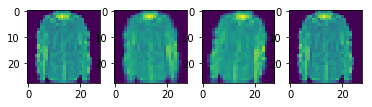

In [53]:
# Let's visualise our transforms

i = 3455

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(x_train[i].reshape(28, 28))
ax2.imshow(x_aug_data[3*(i-1) + 3].reshape(28, 28))
ax3.imshow(x_aug_data[3*(i-1) + 4].reshape(28, 28))
ax4.imshow(x_aug_data[3*(i-1) + 5].reshape(28, 28))

print(y_train[i])

In [54]:
cnn_2 = Sequential()

cnn_2.add(InputLayer(input_shape=(img_rows, img_cols, 1)))
cnn_2.add(BatchNormalization())
cnn_2.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
cnn_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_2.add(Dropout(0.1))
cnn_2.add(Conv2D(64, (4, 4), activation='relu'))
cnn_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_2.add(Dropout(0.3))
cnn_2.add(Flatten())
cnn_2.add(Dense(256, activation='relu'))
cnn_2.add(Dropout(0.5))
cnn_2.add(Dense(64, activation='relu'))
cnn_2.add(BatchNormalization())

cnn_2.add(Dense(7, activation='softmax'))

cnn_2.compile(loss='categorical_crossentropy',
            optimizer=optimizers.Adam(),
            metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [56]:
y_aug_train = keras.utils.to_categorical(y_aug_train)
y_aug_val = keras.utils.to_categorical(y_aug_val)

In [57]:
cnn_2.fit(x_aug_train, y_aug_train, batch_size=batch_size, epochs=40, verbose=1, validation_data=(x_aug_val, y_aug_val))

Instructions for updating:
Use tf.cast instead.
Train on 13500 samples, validate on 4500 samples
Epoch 1/40
13500/13500 [==============================] - 3s 201us/step - loss: 0.9812 - acc: 0.6537 - val_loss: 0.6350 - val_acc: 0.7807
Epoch 2/40
13500/13500 [==============================] - 1s 68us/step - loss: 0.5691 - acc: 0.7859 - val_loss: 0.4322 - val_acc: 0.8320
Epoch 3/40
13500/13500 [==============================] - 1s 67us/step - loss: 0.4845 - acc: 0.8121 - val_loss: 0.4014 - val_acc: 0.8411
Epoch 4/40
13500/13500 [==============================] - 1s 67us/step - loss: 0.4354 - acc: 0.8296 - val_loss: 0.3617 - val_acc: 0.8569
Epoch 5/40
13500/13500 [==============================] - 1s 67us/step - loss: 0.4131 - acc: 0.8372 - val_loss: 0.3525 - val_acc: 0.8620
Epoch 6/40
13500/13500 [==============================] - 1s 70us/step - loss: 0.3772 - acc: 0.8477 - val_loss: 0.3568 - val_acc: 0.8531
Epoch 7/40
13500/13500 [==============================] - 1s 68us/step - loss: 0

In [58]:
score = cnn_2.evaluate(x_aug_val, y_aug_val, verbose=0)
print("Accuracy on the validation set (augmented): ", score[1])

Accuracy on the validation set (augmented):  0.9375555555025736


In [63]:
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
y_val = keras.utils.to_categorical(y_val)

In [65]:
score = cnn_2.evaluate(x_val, y_val, verbose=0)
print("Accuracy on the test set: ", score[1])

Accuracy on the test set:  0.955


`95.5%` - We are good to go. \o/

In [67]:
PATH = "../input/test-images-midas-assignment/"

with open(PATH + "test_image.pkl", 'rb') as f:
    x_final = np.array(pickle.load(f))

x_final = x_final / 255

In [69]:
x_final = x_final.reshape(x_final.shape[0], 28, 28, 1)

In [71]:
y_pred = cnn_2.predict_classes(x_final)

In [72]:
print(y_pred.shape)

(2000,)


In [ ]:
import csv

with open('Rahul_Jha.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['image_index', 'class'])

    for i in range(len(x_final)):
        writer.writerow([i, y_pred[i]])